<a href="https://colab.research.google.com/github/kamijoseph/Advanced-House-Prediction/blob/main/notebook/plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Detection Notebook

In [1]:
#!pip install kaggle tensorflow seaborn

In [2]:
# dependencies
import os
import matplotlib.pyplot as plt
import random
from glob import glob
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

In [3]:
# configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## dataset

In [4]:
# downloading the data
!kaggle datasets download -d emmarex/plantdisease

In [5]:
# unzipping
!unzip -q plantdisease.zip -d plant_village

## exploring the dataset

In [6]:
data_dir = "plant_village/plantvillage/PlantVillage"
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of classes: 15


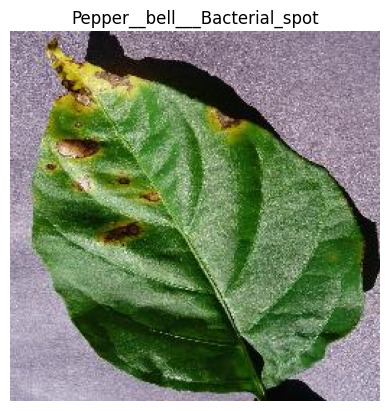

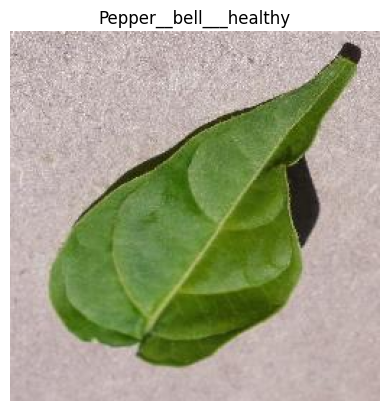

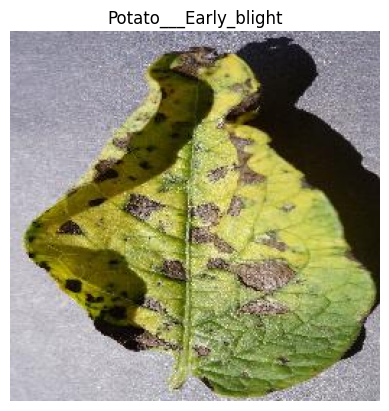

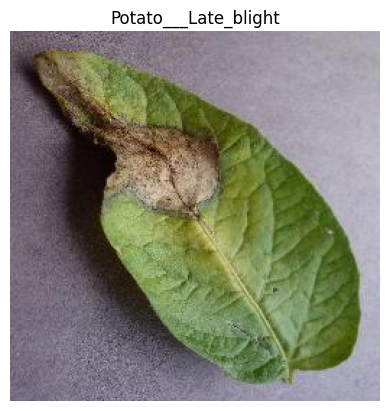

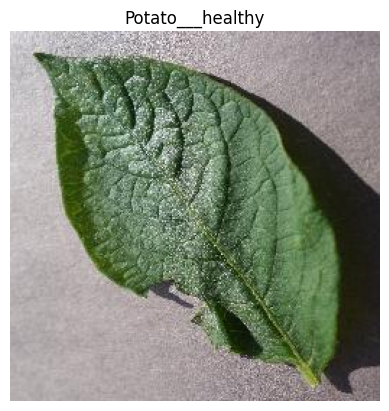

In [7]:
# visualising the first 5
for folder in class_names[:5]:
    folder_path = os.path.join(data_dir, folder)
    img_files = glob(os.path.join(folder_path, "*.JPG"))  # dataset uses uppercase JPG
    if img_files:
        img_path = random.choice(img_files)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"{folder}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No images found in folder: {folder}")

## creating a tensorflow dataset

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.


## data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

##  transfer learning  using EfficientNetB0

In [9]:
base_model = EfficientNetB0(
    include_top = False,
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    weights = "imagenet"
)

# freeze
base_model.trainable = False

NameError: name 'IMG_SIZE' is not defined

In [ ]:
# building the model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
# combining model
model = models.Model(inputs, outputs)

In [ ]:
# compiling the model
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)
model.summary()

In [ ]:
# callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath = "plant_model.keras",
    save_best_only = True,
    monitor = "val_loss",
    mode = "min"
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience = 5,
    restore_best_weights = True,
    monitor = "val_loss",
    mode = "min"
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.5,
    patience=3,
    min_lr = 1e-6,
    monitor = "val_loss",
    mode = "min"
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

## training and evaluating the model

In [ ]:
# training
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 15,
    callbacks = callbacks
)